# Diagrama de Fases

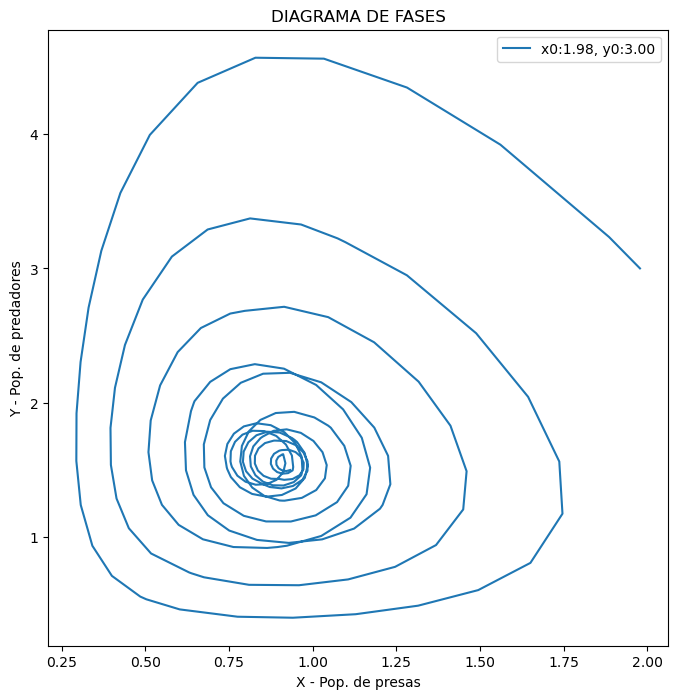

In [5]:
import numpy as np
import pdb
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

as_fun = lambda p: p if callable(p) else lambda t, x, y: float(p)
a0 = 3
b0 = 1.5
c0 = 4.5
d0 = 4.6
e0 = 9e-1
k0 = 6

a = lambda t, x, y : 4*a0/10 + (6*a0/10) * np.exp(-0.1*y)
b = lambda t, x, y : b0
c = lambda t, x, y: c0
d = lambda t, x, y: d0
e = lambda t, x, y: e0
K = lambda t, x, y: k0

def make_fix(e0, hold_dt=0.1, noise_amp=0.5, noise_mul = 1, seed = 42):
    np.random.seed(seed)
    last_t = 0
    noise = np.random.uniform(-noise_amp, noise_amp)

    def __fix(t, x, y, enabled=True, noise_mul = noise_mul):
        '''
        Função responsável por adicionar o ruído estocástico ao valor y(t)
        e criar y_obs
        '''
        nonlocal last_t, noise
        if not enabled:
            return 0.0
        if t - last_t >= hold_dt:
            last_t = t
            noise = np.random.uniform(-noise_amp, noise_amp)

        # se a ideia for "observação em torno de y", use 1 + noise:
        y_obs = y * (noise_mul + noise)
        return e0 * (y_obs - y)

    return __fix

invariante = False

# para mapear constentes para funções, se for o caso
a, b, c, d, e, K = map(
    as_fun, [a, b, c, d, e, K] if not invariante else [a0, b0, c0, d0, e0, k0]
)

def sistema_edo(t, z):
    global _fix
    x, y = z
    results = [
        a(t, x, y) * x - b(t, x, y) * x * y, # = dx/dt
       -c(t, x, y) * y + d(t, x, y) * x * y  + _fix(
           t, x, y
       ) # = dy/dt
    ]
    return results

def sistema_edo_cap_suporte(t, z):
    global _fix
    x, y = z
    return [
        a(t, x, y) * x * (1 - x / K(t, x, y)) - b(t, x, y) * x * y, # = dx/dt
       -c(t, x, y) * y + d(t, x, y) * x * y  + _fix(
           t, x, y
       ) # = dy/dt
    ]

sistema_edo = sistema_edo_cap_suporte

def integrate(
    fn : callable,
    t0,
    tf,
    x0,
    y0
):
    _ivp = [x0, y0]
    sol = solve_ivp(
        fn,
        (t0, tf),
        _ivp,
        method = 'RK45',
        rtol = 1e-6,
        atol = 1e-9,
        dense_output = True
    )
    return sol.t, *sol.y

x_0_array = np.array(
    [c0/d0 + 1]
)
y_0_array = np.array(
    [a0/b0 + 1]
)

plt.figure(figsize = (8, 8))
plt.title('DIAGRAMA DE FASES')
plt.xlabel('X - Pop. de presas')
plt.ylabel('Y - Pop. de predadores')
t_final = 25
data = {}
i = 0
for pair in list(zip(x_0_array, y_0_array)):
    x0, y0 = pair
    _fix = make_fix(e0 = e0, hold_dt = 1.12, noise_amp = 0.3, noise_mul = 1.5, seed = np.random.randint(0,2**31-1))
    t, x, y = integrate(sistema_edo, 0, t_final, x0, y0)
    data[
        f'{x0:.3f}', f'{y0:.3f}'
    ] = (t, x, y)
    plt.plot(x, y, label = f'x0:{x0:.2f}, y0:{y0:.2f}')
plt.legend()
plt.show()

# Populações de Presas e Predadores ao Longo do Tempo

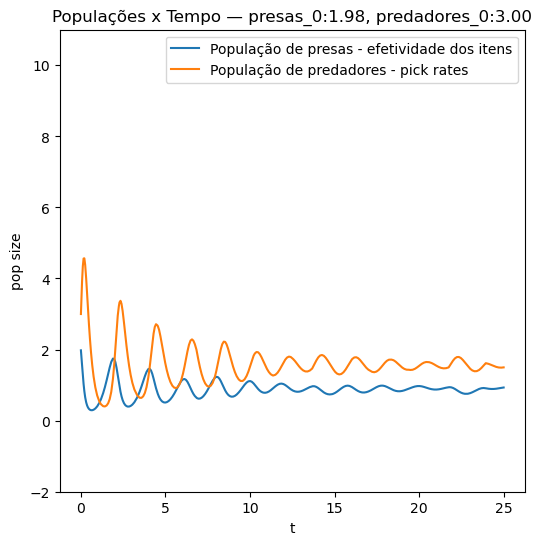

In [7]:
for pair in zip(x_0_array, y_0_array):
    x0, y0 = pair
    a, b, c = data[(f'{x0:.3f}', f'{y0:.3f}')]
    plt.figure(figsize = (6, 6))
    plt.title(f'Populações x Tempo — presas_0:{x0:.2f}, predadores_0:{y0:.2f}')
    plt.xlabel('t')
    plt.ylabel('pop size')
    plt.ylim(-2, 11)
    plt.plot(a, b, label = f'População de presas - efetividade dos itens')
    plt.plot(a, c, label = f'População de predadores - pick rates')
    plt.legend()
    plt.show()